In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import matplotlib as mpl

In [38]:
path = '../background/hyperparameters.csv'
df = pd.read_csv(path)

# order proteins by MW

mws = {'Chignolin': 10, 'Trp-cage': 20, 'BBA': 28, 'Villin': 35, 'WW-domain': 35, 'NTL9': 39, 'BBL': 47, 
      'Protein B': 47, 'Homeodomain': 52, 'Protein G': 56, 'a3D': 73, 'Lambda-repressor': 80}
df['n_res'] = df['Protein'].apply(lambda x: mws[x])
df.sort_values(by=['n_res'], inplace=True)
prot_order = df.copy(deep=True).Protein.unique()

# Create these as ordinal features so that they stay in this order when plotted (hopefully)
df['Protein'] = pd.Categorical(df['Protein'], ordered=True, categories=prot_order)



In [61]:
feats = df.loc[df.Hyperparameter=='feature', ['Citation', 'Protein', 'Value']]

feats = (feats.join(
    feats.Value.str
    .split(pat=',')
    .apply(pd.Series))
    .drop(['Value'], axis=1)
    .melt(id_vars=['Citation', 'Protein'], value_name='Feature')
    .drop(['variable'], axis=1)
    .dropna())
feats.Feature = feats.Feature.str.strip()

feat_labs = {'chi1-dihedral':     r'D: $\chi_{1}$', 
            'backbone-dihedrals': r'D: $(\phi, \psi)$', 
            'alpha-dihedrals':    r'D: $C_{\alpha}$', 
            'all-dihedrals':      r'D: all', 
            'fraction of native contacts' : r'Q: %-native', 
             'contact-map': r'Q: map', 
            'heavy-distances': r'R: $\mathbf{Z}$', 
            'heavy-reciprocal-distances': r'R: $1/\mathbf{Z}$', 
            'beta-distances' : r'R: $C_{\beta}$', 
             'alpha-reciprocal-distances': r'R: $1/C_{\alpha}$', 
             'alpha-logistic-distances': r'R: $\mathrm{logit}{C_{\alpha}}$',
             'alpha-distances': r'R: $C_{\alpha}$',
             'beta-positions': r'X: $C_{\beta}$', 
             'backbone-positions': r'X: backbone', 
             'alpha-angles': r'A: $C_{\alpha}$', 
             'RMSD': r'M: RMSD', 
             'FRET efficiency': r'M: FRET $\eta$'
            }

feats.Feature = feats.Feature.apply(lambda x: feat_labs[x])
feats

,Citation,Protein,Feature
0,A_Minimum_2018,Chignolin,D: $C_{\alpha}$
1,A_Minimum_2018,Chignolin,D: $C_{\alpha}$
2,Modeling_t2017,Chignolin,D: $C_{\alpha}$
3,Quantitati2018,Chignolin,R: $\mathbf{Z}$
4,Optimized_2016,Chignolin,R: $\mathrm{logit}{C_{\alpha}}$
...,...,...,...
128,Quantitati2018,Protein B,D: all
130,Quantitati2018,Homeodomain,D: all
136,Quantitati2018,a3D,D: all
164,A_Data-Dri2018,WW-domain,D: $C_{\alpha}$


# Protein feature

In [62]:
# order features by type and then alphabetical
feats['is_dihedral'] = feats.Feature.str.startswith('D')
feats['is_distance'] = feats.Feature.str.startswith('R')
feats['is_contact'] = feats.Feature.str.startswith('Q')
feats['is_angle'] = feats.Feature.str.startswith('A')
feats['is_position'] = feats.Feature.str.startswith('X')
feats['misc'] = (~feats['is_dihedral']) | (~feats['is_distance']) | (~feats['is_contact']) | (~feats['is_angle']) | (~feats['is_position']) 
feats.sort_values(by=['is_dihedral', 'is_contact', 'is_distance', 'is_position', 'is_angle', 'misc', 'Feature'], inplace=True, ascending=False)
feat_order = feats.copy(deep=True).Feature.unique()


feats['Feature'] = pd.Categorical(feats['Feature'], ordered=True, categories=feat_order)

In [63]:
feat_order

array(['D: all', 'D: $\\chi_{1}$', 'D: $C_{\\alpha}$',
       'D: $(\\phi, \\psi)$', 'Q: map', 'Q: %-native',
       'R: $\\mathrm{logit}{C_{\\alpha}}$', 'R: $\\mathbf{Z}$',
       'R: $C_{\\beta}$', 'R: $C_{\\alpha}$', 'R: $1/\\mathbf{Z}$',
       'R: $1/C_{\\alpha}$', 'X: backbone', 'X: $C_{\\beta}$',
       'A: $C_{\\alpha}$', 'M: RMSD', 'M: FRET $\\eta$'], dtype=object)

In [64]:
sns.set_style('white')

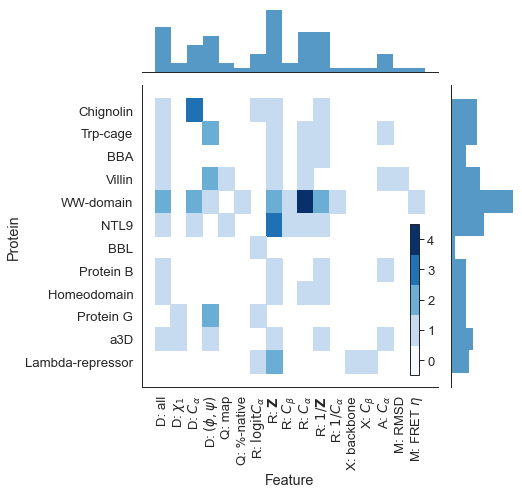

In [93]:

with sns.plotting_context('paper', font_scale=1.5):
    y, x = feats['Protein'], feats['Feature']
    g = sns.JointGrid(height=6, ratio=4)
    
    # plot the data
    sns.histplot(x=x,ax=g.ax_marg_x, fill=True, lw=0)
    sns.histplot(y=y,ax=g.ax_marg_y, fill=True, lw=0)
    sns.histplot(x=x, y=y, ax=g.ax_joint, cmap='Blues')
    # custom colorbar
    cmap = mpl.cm.Blues
    bounds = [0, 1, 2, 3, 4, 5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='neither')
    cbar_ax = g.fig.add_axes([0.72,0.11,  0.02, 0.35])
    cb2 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                    cmap=cmap,
                                    norm=norm,
                                    orientation='vertical', 
                                   ticks=mpl.ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5]), 
                                   format=mpl.ticker.FixedFormatter([0, 1, 2, 3, 4]))
    

    g.fig.axes[0].tick_params(axis='x', labelrotation=90)
    plt.savefig('../figures/background_features.pdf', bbox_inches='tight')

# Markov lag times

In [112]:
mlags = df.loc[df.Hyperparameter.str.lower().str.contains('markov'), ['Citation', 'Protein', 'Hyperparameter', 'Value', 'units']]
mlags.dropna(axis=0, subset=['Value'], inplace=True)
mlags['Value'] = mlags['Value'].astype(float)
mlags['Hyperparameter'] = "Markov lag-time"

# TICA parameters

In [113]:
tica = df.loc[df.Hyperparameter.str.lower().str.contains('tica'), ['Citation', 'Protein', 'Hyperparameter', 'Value', 'units']]

replace = {'kinetic-map': 1, 'commute-map': 2, 'none': 0, 'all': 200, '95pc_KV': np.nan}
def f(x):
    try: 
        return replace[x]
    except KeyError:
        return x

tica['Value'] = tica['Value'].apply(f)
tica.dropna(axis=0, subset=['Value'], inplace=True)
tica['Value'] = tica['Value'].astype(float)
tica = tica.loc[~tica.Hyperparameter.isin(['TICA stride', 'TICA scaling']), :]

In [114]:
hps = pd.concat([mlags, tica])

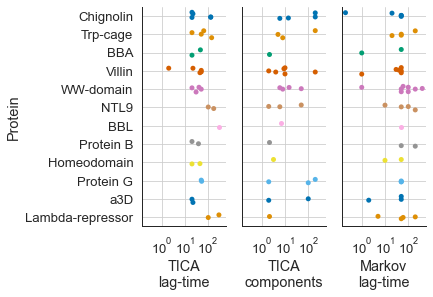

In [125]:
with sns.plotting_context('paper', font_scale=1.5):
    order = np.array(['TICA lag', 'TICA m', 'Markov lag-time'])
    xlabels = ['TICA\nlag-time', 'TICA\ncomponents', 'Markov\nlag-time']
    
    g = sns.catplot(data=hps, col='Hyperparameter', y='Protein', x='Value', sharey=True, 
                    s=5, palette='colorblind', col_order=order, jitter=0.2, height=4, aspect=2/4, alpha=1)
    g.set_titles('')
    for ax in g.axes.flatten():
#         ax.tick_params(axis='x', rotation=90)
        ax.set_xscale('log')
        ax.grid(axis='both')
        
    for i, x in enumerate(order):
        g.axes[0, np.where(order==x)[0][0]].set_xlabel(xlabels[i])

    plt.savefig('../figures/background_hps.pdf', bbox_inches='tight')
    

# Other stats

In [ ]:
# number of citations
df.Citation.unique().shape

In [ ]:
df.head()

In [ ]:
# number of citations using optimisation

In [ ]:
df.loc[df['Uses optimisation']==True, 'Citation'].unique().shape